GPU 사용을 권장합니다.

# 필요한 라이브러리 임포트

1. XML 파일 파싱을 위한 라이브러리

- tarfile

- xml.etree.ElementTree

- os

2. 이미지를 다루기 위한 라이브러리

- PIL

- cv2

3. 데이터 핸들링을 위한 라이브러리

- numpy

- pandas

4. 모델 구현을 위한 라이브러리

- tensorflow

In [ ]:
import tarfile
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as Et
from xml.etree.ElementTree import Element, ElementTree
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd

# 데이터셋 준비하기

먼저 물체 탐지를 위한 데이터 셋을 준비해보겠습니다.

일단 tar파일을 압축해제하고 현재 경로에 파일을 풀어주겠습니다.

In [ ]:
fname = '/content/drive/MyDrive/개인프로젝트/YOLO/VOCtrainval_06-Nov-2007.tar'  
ap = tarfile.open(fname)    
ap.extractall()         
ap.close()               

이제 압축해제된 파일이 보이실 텐데, 정답이 포함된 Annotation, 인풋이 될 JPEGImages 등으로 부터 필요한 것들을 다시 불러줍니다(파일 경로, 파일 이름 등).

In [ ]:
img_path, img_dir, img_files = next(os.walk(os.path.join('/content/VOCdevkit/VOC2007', "JPEGImages")))
ann_path, ann_dir, ann_files = next(os.walk(os.path.join('/content/VOCdevkit/VOC2007', "Annotations")))

이제 xml 파일을 파싱하고 각 위치 정보(xmim, ymin 등..)와 클래스 이름(person, chair 등)등등 필요한 정보를 다시 정리하여 target_df에 담아줍니다.

저희가 입력해줄 변수는 오직 사진이기 때문에 input_df에는 사진 정보만 담아주겠습니다.

여기서 중요한게 있는데 저희가 학습 방법 중 하나로 전이학습을 이용해 줄 것입니다.

그렇게 되면, 이 모델이 만들어 졌을 때의 입력형태와 동일하게 만들어 주어야 하는데 그러기 위해서는 224 x 224 형태로 만들어 주어야 합니다. 이 작업을 cv2.resize로 해줍니다.

또한, 이미지 사이즈가 바뀌게 되면 위치 정보도 그에 따라 스케일링을 해주어야 합니다.

그래서 위치 정보의 비율을 맞춰주도록 하겠습니다.

In [ ]:
target_df= []
input_df = []
for x_file in ann_files:
  img_name = img_files[img_files.index(".".join([x_file.split(".")[0], "jpg"]))]
  img_file = os.path.join(img_path, img_name)
  image = Image.open(img_file).convert("RGB")


  xml_file = open(os.path.join(ann_path, x_file), "r")
  tree = Et.parse(xml_file)
  root = tree.getroot()

  size = root.find('size')

  width = size.find('width').text
  height = size.find('height').text
  channels = size.find('depth').text

  object = root.findall('object')

  for obj in object:
    
    obj_name = obj.find('name').text
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find("xmin").text)
    ymin = int(bndbox.find("ymin").text)
    xmax = int(bndbox.find("xmax").text)
    ymax = int(bndbox.find("ymax").text)
    img_data = cv2.imread(img_file)
    img_resize = cv2.resize(img_data, (224,224), cv2.INTER_AREA)
    input_df.append(img_resize)
    x_scaler = 224/float(width)
    y_scaler = 224/float(height)
    target_df.append([img_name[:-4], xmin * x_scaler, ymin * y_scaler, xmax * x_scaler, ymax * y_scaler, obj_name, width, height, channels])  


일단 이미지 데이터셋이 잘 담겼는지 보겠습니다.

In [ ]:
print(np.array(input_df).shape)

(15662, 224, 224, 3)


그 다음, 위치정보와 클래스 정보가 잘 담겼는지 보겠습니다.

In [ ]:
target_df[0]

['008317',
 33.152,
 26.282666666666668,
 175.616,
 224.00000000000003,
 'bird',
 '500',
 '375',
 '3']

In [ ]:
target_df[1]

['009114',
 46.199999999999996,
 27.471698113207548,
 169.39999999999998,
 201.81132075471697,
 'horse',
 '320',
 '212',
 '3']

그럼 이제 다시 데이터 핸들링을 편하게 하기 위해서 데이터 프레임으로 바꿔줍니다.

In [ ]:
target_info = pd.DataFrame(target_df)
target_info.columns = ['사진이름','xmin','ymin','xmax','ymax','물체','넓이','높이','채널']
target_info

,사진이름,xmin,ymin,xmax,ymax,물체,넓이,높이,채널
0,008317,33.152000,26.282667,175.616000,224.000000,bird,500,375,3
1,009114,46.200000,27.471698,169.400000,201.811321,horse,320,212,3
2,009114,91.700000,11.622642,121.800000,116.226415,person,320,212,3
3,000147,14.784000,70.630631,29.120000,98.210210,chair,500,333,3
4,000147,34.496000,76.684685,51.072000,100.228228,chair,500,333,3
...,...,...,...,...,...,...,...,...,...
15657,004528,3.612903,9.856000,219.664516,121.856000,aeroplane,310,500,3
15658,002082,36.736000,89.006623,103.040000,198.039735,motorbike,500,302,3
15659,002082,43.904000,26.701987,90.944000,179.496689,person,500,302,3
15660,006989,76.608000,56.746667,222.656000,224.000000,cat,500,375,3


그럼, 각 객체들이 얼만큼 있는지 보겠습니다.

다행인건 사람이 제일 많군요!

In [ ]:
target_info['물체'].value_counts()

person         5447
car            1644
chair          1432
bottle          634
pottedplant     625
bird            599
dog             538
sofa            425
bicycle         418
horse           406
boat            398
motorbike       390
cat             389
tvmonitor       367
cow             356
sheep           353
aeroplane       331
train           328
diningtable     310
bus             272
Name: 물체, dtype: int64

사진의 경우 RGB 3개의 채널을 갖습니다. 따라서, 채널이 3개가 아닌 이미지는 걸러내야 합니다.

혹시 채널의 고유값이 3인지 아닌지 살펴보기 위해(사진들이 전부 3채널로 이루어져 있는지) 다음과 같이 실행해봅니다.

다행히, 채널은 모두 3개 입니다!

In [ ]:
target_info['채널'].unique()

array(['3'], dtype=object)

저희가 만들 모델은 사람인지 아닌지와 사진에서 사람의 위치정보를 출력할 모델을 만드는 것이기 때문에, 모든 물체를 사람(1)과 사람이 아닌(0) 것으로 모아주겠습니다.

사람이 총 5,477개의 케이스, 사람이 아닌 경우가 총 10,215개의 케이스가 있네요.

In [ ]:
person_index = target_info[target_info['물체'] == 'person']['물체'].index

not_person_index = target_info[target_info['물체'] != 'person']['물체'].index

target_info['물체'].loc[person_index] = 1
target_info['물체'].loc[not_person_index] = 0

target_info['물체'].value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


0    10215
1     5447
Name: 물체, dtype: int64

데이터가 잘 바뀌었는지 보겠습니다.

In [ ]:
target_info

,사진이름,xmin,ymin,xmax,ymax,물체,넓이,높이,채널
0,008317,33.152000,26.282667,175.616000,224.000000,0,500,375,3
1,009114,46.200000,27.471698,169.400000,201.811321,0,320,212,3
2,009114,91.700000,11.622642,121.800000,116.226415,1,320,212,3
3,000147,14.784000,70.630631,29.120000,98.210210,0,500,333,3
4,000147,34.496000,76.684685,51.072000,100.228228,0,500,333,3
...,...,...,...,...,...,...,...,...,...
15657,004528,3.612903,9.856000,219.664516,121.856000,0,310,500,3
15658,002082,36.736000,89.006623,103.040000,198.039735,0,500,302,3
15659,002082,43.904000,26.701987,90.944000,179.496689,1,500,302,3
15660,006989,76.608000,56.746667,222.656000,224.000000,0,500,375,3


여기도 중요한 부분입니다.

데이터를 들여다 보시면 알시겠지만, 사진 하나에도 여러 객체가 있고, 여러 객체에 대한 정보가 있습니다.

그런데 저희 모델이 YOLO와 다른 점은, grid를 이용해서 바운딩 박스를 생성하는 것이 아니기 때문에 중복된 데이터는 되려 학습을 방해할 우려가 있습니다.

모델이 더 단순한 만큼 오히려 학습을 제대로 하지 못할 가능성이 높기 때문에, 한 이미지에는 하나의 정보만 담기게끔 다시 정제해 줍니다.

In [ ]:
tt=target_info.copy()
tt=tt.reset_index()

tar_person = tt[tt['물체'] == 1].drop_duplicates(['사진이름'])
tar_person.index=tar_person['사진이름']

tar_not_person = tt[tt['물체'] == 0].drop_duplicates(['사진이름'])
tar_not_person.index=tar_not_person['사진이름']

먼저 사람이 담긴 이미지 데이터 프레임부터 보겠습니다.

In [ ]:
tar_person

,index,사진이름,xmin,ymin,xmax,ymax,물체,넓이,높이,채널
사진이름,,,,,,,,,,
009114,2,009114,91.700000,11.622642,121.800000,116.226415,1,320,212,3
004010,11,004010,52.864000,4.287081,201.600000,224.000000,1,500,418,3
004660,13,004660,197.120000,51.370667,205.184000,73.472000,1,500,375,3
001836,17,001836,25.536000,46.592000,143.360000,218.026667,1,500,375,3
002858,19,002858,107.627628,14.784000,186.330330,155.904000,1,333,500,3
...,...,...,...,...,...,...,...,...,...,...
006943,15649,006943,28.672000,94.976000,39.424000,137.984000,1,500,375,3
009306,15654,009306,29.269333,33.152000,222.208000,198.912000,1,375,500,3
004528,15656,004528,23.845161,44.800000,110.554839,126.784000,1,310,500,3


그 다음, 사람이 아닌 물체가 담긴 데이터 프레임을 보겠습니다.

In [ ]:
tar_not_person

,index,사진이름,xmin,ymin,xmax,ymax,물체,넓이,높이,채널
사진이름,,,,,,,,,,
008317,0,008317,33.152000,26.282667,175.616000,224.000000,0,500,375,3
009114,1,009114,46.200000,27.471698,169.400000,201.811321,0,320,212,3
000147,3,000147,14.784000,70.630631,29.120000,98.210210,0,500,333,3
004010,10,004010,0.448000,71.808612,224.000000,193.990431,0,500,418,3
004660,12,004660,0.448000,77.056000,17.920000,97.365333,0,500,375,3
...,...,...,...,...,...,...,...,...,...,...
008890,15652,008890,65.706667,68.992000,213.845333,111.552000,0,375,500,3
009306,15653,009306,40.021333,151.424000,158.890667,202.048000,0,375,500,3
004528,15657,004528,3.612903,9.856000,219.664516,121.856000,0,310,500,3


자 그러면 이제, 사람이 아닌 데이터셋에 있는 사진 중 곂치는 목록은 빼주겠습니다.

In [ ]:
for p_ind in tar_person['사진이름']:
  if (p_ind in tar_not_person['사진이름'].unique()) == True:
    tar_not_person = tar_not_person.drop([p_ind],axis=0)
tar_not_person

,index,사진이름,xmin,ymin,xmax,ymax,물체,넓이,높이,채널
사진이름,,,,,,,,,,
008317,0,008317,33.152000,26.282667,175.616000,224.000000,0,500,375,3
000147,3,000147,14.784000,70.630631,29.120000,98.210210,0,500,333,3
008988,25,008988,0.896000,56.746667,168.000000,196.522667,0,500,375,3
001360,26,001360,3.136000,62.527607,200.704000,186.895706,0,500,326,3
005576,27,005576,8.512000,150.018349,216.832000,211.669725,0,500,109,3
...,...,...,...,...,...,...,...,...,...,...
007458,15622,007458,147.840000,132.608000,224.000000,224.000000,0,500,375,3
004956,15638,004956,77.357357,101.248000,101.573574,119.168000,0,333,500,3
008386,15640,008386,68.992000,33.450667,114.688000,96.768000,0,500,375,3


이렇게 잘 정제된 데이터셋을 합쳐주도록 하겠습니다.

그러고 나니 총 5,011개의 데이터가 모였습니다.

In [ ]:
targets = pd.concat([tar_person, tar_not_person],axis=0)
targets = targets.drop_duplicates(['사진이름'])

targets

,index,사진이름,xmin,ymin,xmax,ymax,물체,넓이,높이,채널
사진이름,,,,,,,,,,
009114,2,009114,91.700000,11.622642,121.800000,116.226415,1,320,212,3
004010,11,004010,52.864000,4.287081,201.600000,224.000000,1,500,418,3
004660,13,004660,197.120000,51.370667,205.184000,73.472000,1,500,375,3
001836,17,001836,25.536000,46.592000,143.360000,218.026667,1,500,375,3
002858,19,002858,107.627628,14.784000,186.330330,155.904000,1,333,500,3
...,...,...,...,...,...,...,...,...,...,...
007458,15622,007458,147.840000,132.608000,224.000000,224.000000,0,500,375,3
004956,15638,004956,77.357357,101.248000,101.573574,119.168000,0,333,500,3
008386,15640,008386,68.992000,33.450667,114.688000,96.768000,0,500,375,3


그럼 이제 입력해줄 이미지 데이터셋에도 똑같이 중복된 사진을 빼주겠습니다.

In [ ]:
input_df = np.array(input_df)[targets['index']]

target_df = targets

마지막으로, 필요없는 정보(사진 이름, 넓이, 높이 등)는 날려주겠습니다.

이제 데이터는 준비가 얼추 다 됐습니다.

다음은 모델을 구축해보겠습니다.

In [ ]:
target_df = target_df.drop(['사진이름'],axis=1).reset_index(drop=True).drop(['index','넓이','높이','채널'],axis=1)
target_df

,xmin,ymin,xmax,ymax,물체
0,91.700000,11.622642,121.800000,116.226415,1
1,52.864000,4.287081,201.600000,224.000000,1
2,197.120000,51.370667,205.184000,73.472000,1
3,25.536000,46.592000,143.360000,218.026667,1
4,107.627628,14.784000,186.330330,155.904000,1
...,...,...,...,...,...
5006,147.840000,132.608000,224.000000,224.000000,0
5007,77.357357,101.248000,101.573574,119.168000,0
5008,68.992000,33.450667,114.688000,96.768000,0
5009,123.648000,135.475983,162.624000,172.646288,0


# 모델 구현

이제 사전 학습된 모델을 불러와 이를 이용해볼 건데, 추가로 몇개의 레이어를 더 쌓고 물체 탐지에 맞게 모델의 구조를 좀 조정해 줄 것입니다.

사용할 모델은 "ResNet50" 모델이며 이 역시 imagenet 데이터셋에서 훌륭한 성능을 보여주었던 모델 중 하나입니다.

그럼 시작해봅시다.

먼저 전이 학습(transfer learning)을 진행할 모델을 불러오겠습니다.

In [ ]:
trans_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet',input_shape=[224,224,3])
trans_model

94781440/94765736 [==============================] - 1s 0us/step


모델을 학습시키기 전에 해야할 것은 불러온 모델들의 레이어를 동결시켜줘야 하는 것 입니다.

모델을 불러와 바로 학습을 진행하게 되면 사전 학습된 가중치들이 망가지기 때문 입니다.

In [ ]:
for layer in trans_model.layers:
  layer.trainable = False

모델이 어떤 구조인지 한번 보겠습니다.

In [ ]:
trans_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

그 다음, 물체 탐지에 맞게 모델의 구조를 조정해줍니다.

먼저 전역평균 풀링층을 추가하고, flatten으로 레이어를 펼친 후, yolo논문과 비슷하게 dropout, LeakyReLU 활성화 함수 등을 추가시킵니다.

In [ ]:
avg_layer = tf.keras.layers.GlobalAveragePooling2D()(trans_model.output)
flatten = tf.keras.layers.Flatten()(avg_layer)
drop1 = tf.keras.layers.Dropout(0.5)(flatten)
batch1 = tf.keras.layers.BatchNormalization()(drop1)
dense1 = tf.keras.layers.Dense(1200)(batch1)
leaky = tf.keras.layers.LeakyReLU()(dense1)
drop2 = tf.keras.layers.Dropout(0.5)(leaky)
batch2 = tf.keras.layers.BatchNormalization()(drop2)

dense2 = tf.keras.layers.Dense(1000)(batch2)
leaky2 = tf.keras.layers.LeakyReLU(0.4)(dense2)

그리고 모델의 끝에는 각 위치 좌표를 출력해줄 뉴런과, 물체의 종류를 인식할 뉴런도 쌓아주겠습니다.

In [ ]:
xmin_output = tf.keras.layers.Dense(1)(leaky2)
ymin_output = tf.keras.layers.Dense(1)(leaky2)
xmax_output = tf.keras.layers.Dense(1)(leaky2)
ymax_output = tf.keras.layers.Dense(1)(leaky2)

class_output = tf.keras.layers.Dense(1, activation='sigmoid')(leaky2)

이제 최종적으로 모델을 완성해보겠습니다.

한번 모델을 요약해 볼까요?

In [ ]:
detection = tf.keras.Model(inputs=[trans_model.input], outputs = [xmin_output,ymin_output,xmax_output,ymax_output, class_output])
detection.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

이제 모델을 컴파일 해줄 건데, 각 아웃풋에 맞는 손실함수와 모니터링 지표를 설정해줍니다.

참고로 옵티마이저 함수는 Adam을 설정해줬는데, 흔히 사용하는 sgd는 loss가 폭발해버려서 적절한 옵티마이저 함수를 설정해 주어야 합니다.

더 중요한건, 처음에 전이 학습을 위해 모델을 불러오고 가중치를 동결시킨 다음에는 모델의 효율적인 학습을 위해 학습률을 조금 크게 지정해줄 필요가 있습니다.

In [ ]:
rmse = tf.keras.metrics.RootMeanSquaredError()
detection.compile(loss = ['mse','mse','mse','mse','binary_crossentropy'], metrics =[rmse,'accuracy'], optimizer = tf.keras.optimizers.Adam(learning_rate =0.05))

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('detection_model.h5', save_best_only=True, monitor = 'accuracy')

다시 데이터 파트로 돌아와서, 이미지 데이터를 모델에 입력시킬 때 tensor로 잘 변환이 되게끔 전처리를 해줍니다.

In [ ]:
dd=pd.DataFrame()
for i in input_df:
  dd=dd.append([[i]])
print(dd)
dd = dd.reset_index(drop=True)
dd.columns = ['image']

                                                    0
0   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...
0   [[[2, 14, 20], [3, 15, 21], [4, 16, 25], [4, 1...
0   [[[255, 255, 254], [255, 255, 254], [254, 255,...
0   [[[10, 11, 32], [10, 11, 31], [8, 8, 27], [11,...
0   [[[20, 21, 17], [18, 19, 15], [21, 22, 18], [1...
..                                                ...
0   [[[168, 165, 167], [165, 160, 162], [186, 177,...
0   [[[90, 103, 119], [79, 92, 108], [80, 94, 110]...
0   [[[104, 110, 105], [109, 115, 110], [107, 113,...
0   [[[230, 194, 156], [228, 192, 155], [227, 191,...
0   [[[150, 186, 250], [151, 189, 253], [150, 193,...

[5011 rows x 1 columns]


In [ ]:
dd

,image
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ..."
1,"[[[2, 14, 20], [3, 15, 21], [4, 16, 25], [4, 1..."
2,"[[[255, 255, 254], [255, 255, 254], [254, 255,..."
3,"[[[10, 11, 32], [10, 11, 31], [8, 8, 27], [11,..."
4,"[[[20, 21, 17], [18, 19, 15], [21, 22, 18], [1..."
...,...
5006,"[[[168, 165, 167], [165, 160, 162], [186, 177,..."
5007,"[[[90, 103, 119], [79, 92, 108], [80, 94, 110]..."
5008,"[[[104, 110, 105], [109, 115, 110], [107, 113,..."
5009,"[[[230, 194, 156], [228, 192, 155], [227, 191,..."


이제 데이터 처리의 마지막 입니다.

모델의 효율적인 학습을 위해서 이미지의 픽셀들을 0과 1사이로 조정해주기 위해 255로 나누어 주도록 하겠습니다.

또한, 데이터의 타입도 적절하게 변환시켜 주도록 하겠습니다.

In [ ]:
input_df = []
for i in dd['image']:
  input_df.append(i.astype('float32')/255)
print(np.array(input_df).shape)

(5011, 224, 224, 3)


그에 맞게 출력될 데이터의 타입도 적절하게 변환시켜 주도록 하겠습니다.

In [ ]:
target_df = target_df.astype('float32')

이제 모델에 데이터를 입력 시켜주기 위한 준비를 하겠습니다.

y_param의 경우 위치 정보 4가지와 클래스 정보에 대한 정보가 담겨 있습니다.

In [ ]:
x_param = np.array(input_df)
y_param = [np.array(target_df['xmin']), np.array(target_df['ymin']), np.array(target_df['xmax']), np.array(target_df['ymax']), np.array(target_df['물체'])]

그리고 불필요한 데이터셋들을 초기화 시켜 메모리 사용량을 확보해 줍니다.

In [ ]:
img_files = []
ann_files = []
target_info = []
tt = []
tar_person = []
tar_not_person= []
targets = []
input_df = []
target_df = []

학습을 시작해 볼까요?

저는 에폭을 10정도로만 했지만 사실 물체 탐지를 구현하기 위해서는 충분한 시간과 에폭을 설정해야 합니다.

In [ ]:
history = detection.fit(x=x_param, y=y_param, epochs=10,  workers=-1, callbacks= checkpoint, validation_split = 0.3, shuffle=True)

Epoch 1/10
110/110 [==============================] - 53s 336ms/step - loss: 38341.3984 - dense_2_loss: 8661.5566 - dense_3_loss: 7500.6914 - dense_4_loss: 10870.9814 - dense_5_loss: 11281.5303 - dense_6_loss: 26.6474 - dense_2_root_mean_squared_error: 93.0675 - dense_2_accuracy: 0.0000e+00 - dense_3_root_mean_squared_error: 86.6065 - dense_3_accuracy: 0.0000e+00 - dense_4_root_mean_squared_error: 104.2640 - dense_4_accuracy: 0.0000e+00 - dense_5_root_mean_squared_error: 106.2145 - dense_5_accuracy: 0.0000e+00 - dense_6_root_mean_squared_error: 0.6714 - dense_6_accuracy: 0.5361 - val_loss: 11008.2432 - val_dense_2_loss: 2404.4705 - val_dense_3_loss: 2169.0952 - val_dense_4_loss: 4235.7075 - val_dense_5_loss: 2181.3569 - val_dense_6_loss: 17.6109 - val_dense_2_root_mean_squared_error: 49.0354 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_root_mean_squared_error: 46.5736 - val_dense_3_accuracy: 0.0000e+00 - val_dense_4_root_mean_squared_error: 65.0823 - val_dense_4_accuracy: 0.0000e+0

그 다음, 동결시켰던 가중치를 다시 풀어주고 그 가중치들을 포함해서 한번 더 학습시켜주도록 하겠습니다.

In [ ]:
for layer in detection.layers:
  layer.trainable = True
detection.compile(loss = ['mse','mse','mse','mse','binary_crossentropy'], metrics =[rmse,'accuracy'], optimizer = tf.keras.optimizers.Adam(learning_rate =0.005))
history = detection.fit(x=x_param, y=y_param, epochs=10,  workers=-1, callbacks= checkpoint, validation_split = 0.3, shuffle=True)

Epoch 1/10
110/110 [==============================] - 99s 804ms/step - loss: 10153.4336 - dense_2_loss: 3103.5928 - dense_3_loss: 1912.5698 - dense_4_loss: 2979.3987 - dense_5_loss: 2156.8743 - dense_6_loss: 0.9983 - dense_2_root_mean_squared_error: 55.7099 - dense_2_accuracy: 0.0000e+00 - dense_3_root_mean_squared_error: 43.7329 - dense_3_accuracy: 0.0000e+00 - dense_4_root_mean_squared_error: 54.5839 - dense_4_accuracy: 0.0000e+00 - dense_5_root_mean_squared_error: 46.4422 - dense_5_accuracy: 0.0000e+00 - dense_6_root_mean_squared_error: 0.5697 - dense_6_accuracy: 0.5321 - val_loss: 8896.5195 - val_dense_2_loss: 2704.2043 - val_dense_3_loss: 2049.9768 - val_dense_4_loss: 2586.8835 - val_dense_5_loss: 1553.5142 - val_dense_6_loss: 1.9416 - val_dense_2_root_mean_squared_error: 52.0020 - val_dense_2_accuracy: 0.0000e+00 - val_dense_3_root_mean_squared_error: 45.2767 - val_dense_3_accuracy: 0.0000e+00 - val_dense_4_root_mean_squared_error: 50.8614 - val_dense_4_accuracy: 0.0000e+00 - val

사실 학습과정을 지켜보면 점점 학습률을 조정해 가면서 에폭을 늘리고, loss를 좀더 많이 줄여야 하긴 합니다.

실제로도 yolo의 저자들은 꽤 오랫동안 학습을 진행했다고 합니다.

그래서 더 정확하고 쓸만한 성능을 내기 위해서는 오랫동안 천천히 학습률과 여러 파라미터들을 조정해 줘야 하지만, 단순히 구현하는 것 만으로는 충분합니다. 

그럼 이제 확인해볼까요?

제 사진을 인식시켜보겠습니다.



In [ ]:
input_img = cv2.imread('./imagee.jpg')
input_img = cv2.resize(input_img,(224,224), cv2.INTER_AREA)
input_img = input_img/255
input_img = np.array(input_img, dtype='float32')
input_img

array([[[0.78039217, 0.627451  , 0.5019608 ],
        [0.78039217, 0.627451  , 0.5019608 ],
        [0.78039217, 0.627451  , 0.5019608 ],
        ...,
        [0.8352941 , 0.76862746, 0.7058824 ],
        [0.8392157 , 0.77254903, 0.70980394],
        [0.84313726, 0.77254903, 0.7137255 ]],

       [[0.78039217, 0.627451  , 0.5019608 ],
        [0.78039217, 0.627451  , 0.5019608 ],
        [0.78039217, 0.627451  , 0.5019608 ],
        ...,
        [0.83137256, 0.76862746, 0.7058824 ],
        [0.8352941 , 0.77254903, 0.70980394],
        [0.8392157 , 0.7764706 , 0.7137255 ]],

       [[0.78039217, 0.627451  , 0.5019608 ],
        [0.78039217, 0.627451  , 0.5019608 ],
        [0.7764706 , 0.62352943, 0.49803922],
        ...,
        [0.83137256, 0.76862746, 0.7058824 ],
        [0.83137256, 0.76862746, 0.7058824 ],
        [0.8352941 , 0.77254903, 0.70980394]],

       ...,

       [[0.42352942, 0.4       , 0.3647059 ],
        [0.3882353 , 0.36078432, 0.32941177],
        [0.42352942, 0

차례대로, x,y에 대한 좌표들이 나와있고 마지막에 제 사진에 대한 판단점수가 나와있습니다.

그런데 제 사진을 사람이라고 확신하진 못하고 있는데 아직 학습이 덜된 것 같습니다. ㅎ

아무튼 계속 해볼게요.

In [ ]:
result = detection.predict(np.array([input_img]))
result

[array([[62.11952]], dtype=float32),
 array([[85.064545]], dtype=float32),
 array([[140.30515]], dtype=float32),
 array([[156.23749]], dtype=float32),
 array([[0.13739006]], dtype=float32)]

위에 저희가 전처리해준바로는 사진의 사이즈를 조정해주면서 위치 좌표도 스케일링 해주었었습니다.

따라서 이번엔 다시 좌표값을 되돌려주면 됩니다.

In [ ]:
ss = cv2.imread('./imagee.jpg')
ss.shape

(961, 720, 3)

In [ ]:
a = result[0][0][0] *(ss.shape[0]/224)
b = result[1][0][0] *(ss.shape[1]/224)
c = result[2][0][0] *(ss.shape[0]/224)
d = result[3][0][0] *(ss.shape[1]/224)

이제 모두 끝났습니다!

저의 어디까지를 사람이라고 인식하는지 보겠습니다.

그 부분을 빨간색 바운딩 박스로 표시하겠습니다.

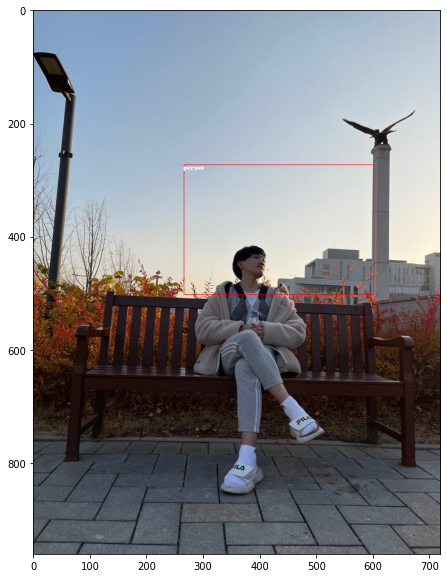

In [ ]:
img_1 = Image.open('imagee.jpg').convert("RGB")
draw = ImageDraw.Draw(img_1)
draw.rectangle(((a, b), (c, d)), outline="red")
draw.text((a, b), 'person')
plt.figure(figsize=(25,10))
plt.imshow(img_1)
plt.show()
plt.close()

# References

1. Redmon, J., Divvala, S., Girshick, R., Farhadi, A. (2016). You only look once: Unified, real-Time object detection. CVPR, 779-788.

2. https://bkshin.tistory.com/entry/OpenCV-6-dd

3. https://lee-mandu.tistory.com/519?category=838684

